In [1]:
## imports
import pandas as pd
import numpy as np
import re
import requests
import yaml
import pickle
from statistics import mean

import census
import janitor
from census import Census
import us
from us import states


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression


import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd


import contextily as ctx
## repeated printouts
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

In [32]:
key = input("Enter census key:")
print(key)
conn = Census(key)

### Calling pre processed datasets from cleaning and clustering steps

In [3]:
acs_9yr_imputed = pd.read_hdf('../acs_pre_clustering.h5', 'acs') #Load level 1 cleaned dataset
acs_final = pd.read_hdf('../acs_clustered.h5', 'acs') #load data set with labels obtained from clustering 

### Some New variables that will be used in predictions

In [4]:
#featurs to be used in prediction

var = ['B01001_001E', #total by age
        'B01001_020E', #men 65+ 
        'B01001_021E',
        'B01001_022E',
        'B01001_023E',
        'B01001_024E',
        'B01001_025E',
        'B01001_044E',#women 65+
        'B01001_045E',
        'B01001_046E',
        'B01001_047E',
        'B01001_048E',
        'B01001_049E',

        'B17021_001E', #Total pop by income
        'B17021_002E',#number of people with income below poverty line
        'B25005_003E', #number of vacant units where current residence is elsewhere 
        'B25001_001E',#total units 
        'B25034_006E',#number of houses older then 1980 
        'B25034_007E',#and older 
        'B25034_008E',#and older
        'B25034_009E',#and older
        'B25034_010E',#and older
        'B25034_001E',#total units by age 
        'B25070_008E',#number of renters whose rent is 35-44% of income
        'B25070_009E',#number of renters whose rent is 45-49% of income
        'B25070_010E',#number of renters whose rent is > 50% of income
        'B25070_001E',#total renters
        'B25003_003E',#number of renters
        'B25003_001E',#total number of inhabitants (renters+owners)
        'C18120_002E', #number of unemplyed person
        'C18120_006E'] #total number in labour force 

In [5]:
g = globals()
for i in range(2012,2022):
    varname = 'acs2_{}'.format(i) ##iteratively create variable with format acs_'year'
    
    ##create dataframe for that particular year, get data at zipcode level
    g[varname] = pd.DataFrame(conn.acs5.get(var, geo={'for': 'tract:*', 'in': 'state:11'}, year = i))
    
    ## adding year column 
    g[varname]['Year'] = i 

acs2_9yr = pd.concat([acs2_2012,acs2_2013,acs2_2014,acs2_2015,acs2_2016,acs2_2017,acs2_2018,acs2_2019,acs2_2020, acs2_2021]) 


### Pre-processing

In [6]:
acs2_9yr['prop_old'] = acs2_9yr[['B01001_020E', 
                                    'B01001_021E',
                                    'B01001_022E',
                                    'B01001_023E',
                                    'B01001_024E',
                                    'B01001_025E',
                                    'B01001_044E',
                                    'B01001_045E',
                                    'B01001_046E',
                                    'B01001_047E',
                                    'B01001_048E',
                                    'B01001_049E']].sum(axis=1)/acs2_9yr['B01001_001E']

acs2_9yr['prop_bpl'] = acs2_9yr['B17021_002E']/acs2_9yr['B17021_001E']
acs2_9yr['prop_vacant'] = acs2_9yr['B25005_003E']/acs2_9yr['B25001_001E']

acs2_9yr['old_house_stock'] = acs2_9yr[['B25034_006E',
                                        'B25034_007E',
                                        'B25034_008E',
                                        'B25034_009E',
                                        'B25034_010E']].sum(axis=1)/acs2_9yr['B25034_001E']

acs2_9yr['prop_rent_burdened'] = acs2_9yr[['B25070_008E',
                                            'B25070_009E',
                                            'B25070_010E',]].sum(axis=1)/acs2_9yr['B25070_001E']

acs2_9yr['prop_renter'] = acs2_9yr['B25003_003E']/acs2_9yr['B25003_001E']
acs2_9yr['perc_unemp'] = acs2_9yr['C18120_006E']/acs2_9yr['C18120_002E']

#no missing values 

In [7]:
#keeping pertinant variables from acs2 for random forests
helper1 = acs2_9yr[['Year','tract','prop_old','prop_bpl', 'prop_vacant','old_house_stock','prop_rent_burdened','prop_renter','perc_unemp']]

#adding per capita income and proportion of longterm residents, variables from acs(acs dataset used for clustering)
#only adding values for census tracts which were used in clustering, since we only have labels for these from clustering
helper2 = acs_9yr_imputed[acs_9yr_imputed.tract.isin(list(acs_final.tract.unique()))][['Year','tract','pcap_inc_overall','prop_long_res']]

rf_df = pd.merge (helper2,helper1, left_on =['Year','tract'], right_on =['Year','tract'], how = 'left' )

In [8]:
#keeping only 2012 data, since we want to train and test on 2012 data, to predict for 2021 and then compare with labels.
#then we do the actual prediction on 2021 data to predict gentrification in 2031. 
rf_2012 = rf_df[rf_df.Year == 2012].dropna().merge(acs_final[['tract','label']], left_on = 'tract', right_on = 'tract', how = 'left')


In [9]:
rf_2012.sort_values(by = 'pcap_inc_overall', ascending = False)

Year   tract  pcap_inc_overall  prop_long_res  prop_old  prop_bpl  \
29   2012  000400     144596.417778       0.266756  0.189564  0.070013   
65   2012  006600     130256.062222       0.223443  0.132361  0.050026   
97   2012  004100     123471.288889       0.392438  0.191956  0.061007   
30   2012  000902     117951.493333       0.416558  0.142050  0.033449   
114  2012  000502     117743.422222       0.351774  0.124512  0.045839   
..    ...     ...               ...            ...       ...       ...   
7    2012  009801      14638.275556       0.220522  0.102999  0.425926   
73   2012  007406      13784.711111       0.207520  0.039930  0.425197   
67   2012  007408      13382.755556       0.070608  0.031666  0.537500   
74   2012  007401      12310.480000       0.410567  0.063601  0.530022   
149  2012  010800       8737.804444       0.082844  0.013908  0.578502   

     prop_vacant  old_house_stock  prop_rent_burdened  prop_renter  \
29      0.118156         0.636888            0.308642     0.264706   
65      0.198467         0.936116            0.152225     0.459634   
97      0.105505         0.995413            0.358726     0.488829   
30      0.066741         0.837597            0.336957     0.112469   
114     0.075640         0.994438            0.307512     0.512635   
..           ...              ...                 ...          ...   
7       0.315725         0.696560            0.525386     0.813285   
73      0.089552         0.705004            0.410231     0.961427   
67      0.163738         0.906550            0.513320     0.932187   
74      0.162745         0.842157            0.332461     0.908442   
149     0.096375         0.923077            0.583710     0.927597   

     perc_unemp                   label  
29     0.020000              affordable  
65     0.008907              affordable  
97     0.068027              affordable  
30     0.043966              affordable  
114    0.024752              affordable  
..          ...                     ...  
7      0.332770            City Average  
73     0.235902             gentrifying  
67     0.276440             gentrifying  
74     0.324421  intense gentrification  
149    0.056404            City Average  

[151 rows x 12 columns]

### EDA

<Figure size 960x800 with 0 Axes>

Text(0.5, 1.0, 'Correlogram of demographics')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'Per capita income'),
  Text(1.5, 0, 'Percentage of long term residents'),
  Text(2.5, 0, 'Percentage of 65+ population'),
  Text(3.5, 0, 'Percentage of population below poverty line'),
  Text(4.5, 0, 'Percentage of vacant house'),
  Text(5.5, 0, 'Percentage housing stocker older than 1980'),
  Text(6.5, 0, 'Percentage of rent burdened population'),
  Text(7.5, 0, 'Proportion of renters'),
  Text(8.5, 0, 'Percentage of unemployed population')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'Per capita income'),
  Text(0, 1.5, 'Percentage of long term residents'),
  Text(0, 2.5, 'Percentage of 65+ population'),
  Text(0, 3.5, 'Percentage of population below poverty line'),
  Text(0, 4.5, 'Percentage of vacant house'),
  Text(0, 5.5, 'Percentage housing stocker older than 1980'),
  Text(0, 6.5, 'Percentage of rent burdened population'),
  Text(0, 7.5, 'Proportion of renters'),
  Text(0, 8.5, 'Percentage of unemployed population')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'Per capita income'),
  Text(1.5, 0, 'Percentage of long term residents'),
  Text(2.5, 0, 'Percentage of 65+ population'),
  Text(3.5, 0, 'Percentage of population below poverty line'),
  Text(4.5, 0, 'Percentage of vacant house'),
  Text(5.5, 0, 'Percentage housing stocker older than 1980'),
  Text(6.5, 0, 'Percentage of rent burdened population'),
  Text(7.5, 0, 'Proportion of renters'),
  Text(8.5, 0, 'Percentage of unemployed population')])

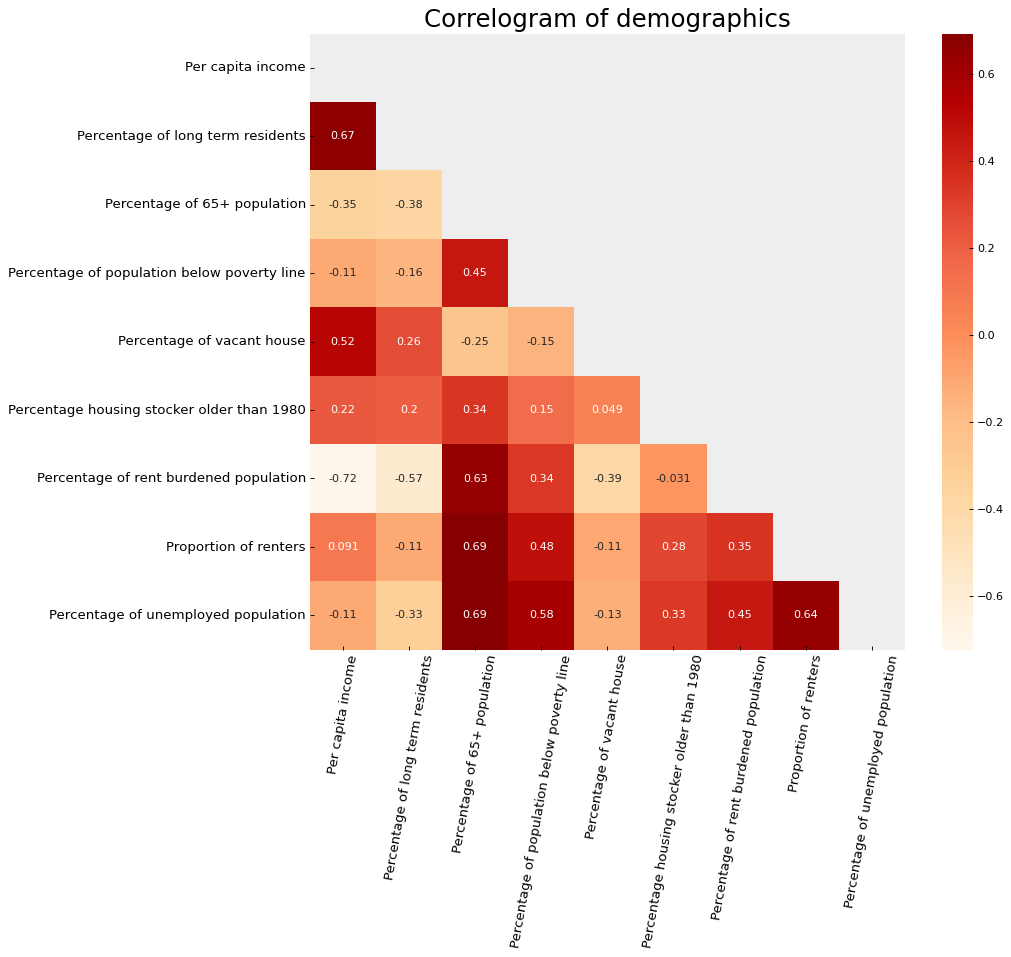

In [35]:
# plt.figure(figsize=(12,10), dpi= 80)
# cor = rf_2012.iloc[:,3:13].corr()
# matrix = np.triu(cor)
# sns.heatmap(cor, xticklabels=rf_df.iloc[:,2:13].corr().columns, yticklabels=rf_df.iloc[:,2:13].corr().columns, cmap='OrRd', mask = matrix,center=0, annot=True)

# # Decorations
# plt.title('Correlogram of demographics', fontsize=22)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()
labels = ['Per capita income','Percentage of long term residents', 'Percentage of 65+ population','Percentage of population below poverty line',
          'Percentage of vacant house','Percentage housing stocker older than 1980','Percentage of rent burdened population',
          'Proportion of renters','Percentage of unemployed population']
plt.figure(figsize=(12,10), dpi= 80)
cor = rf_2012.iloc[:,3:13].corr()
matrix = np.triu(cor)
g = sns.heatmap(cor, xticklabels=labels, yticklabels=labels, cmap='OrRd', mask = matrix,center=0, annot=True)

# Decorations
plt.title('Correlogram of demographics', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation = 80)
plt.show()


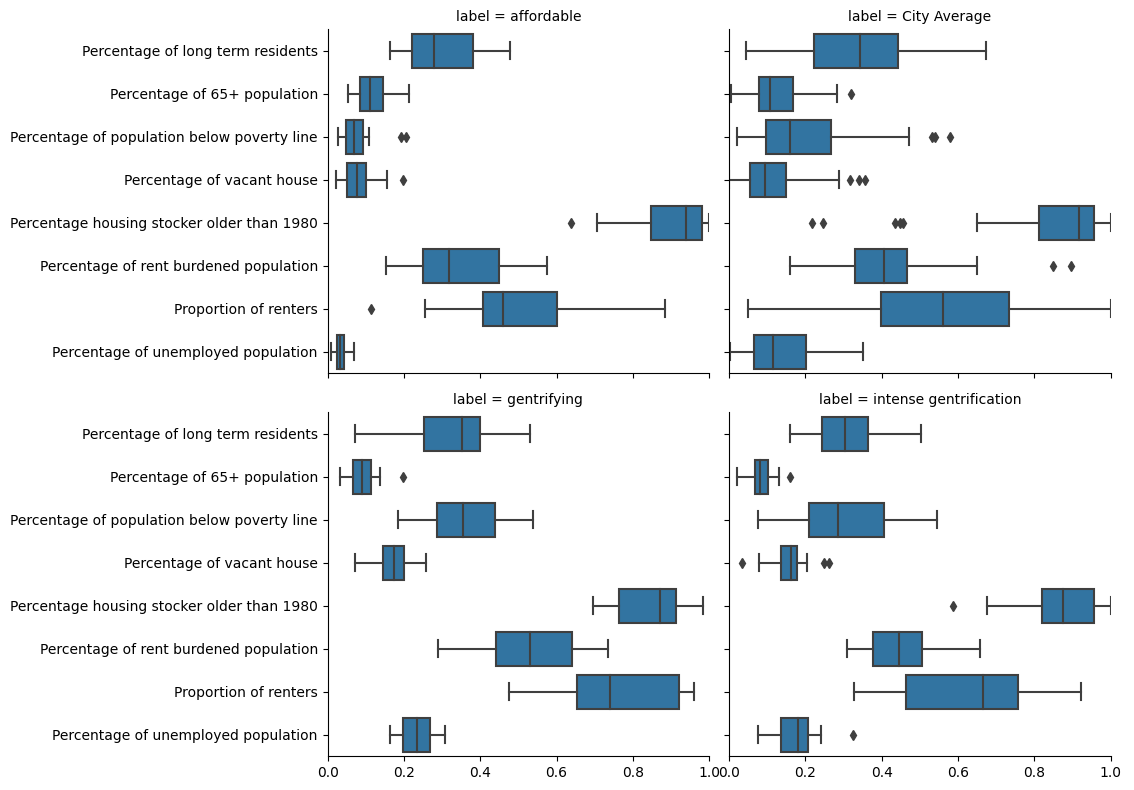

In [11]:
labels = ['Percentage of long term residents', 'Percentage of 65+ population','Percentage of population below poverty line',
          'Percentage of vacant house','Percentage housing stocker older than 1980','Percentage of rent burdened population',
          'Proportion of renters','Percentage of unemployed population']
plot_df = rf_2012.copy()
plot_df.drop(columns = 'pcap_inc_overall', inplace = True)
plot_df = plot_df[['prop_long_res','prop_old','prop_bpl','prop_vacant','old_house_stock','prop_rent_burdened',
                  'prop_renter','perc_unemp','label']]

g = sns.FacetGrid(plot_df, col = 'label', height=4, aspect = 1.2,col_wrap=2)
g.map_dataframe(sns.boxplot, orient = 'h')
g.set(xlim=(0, 1), xticks=[0,0.2,0.4,0.6,0.8,1])
g.set_yticklabels(labels)
g.add_legend()


In [12]:
plot_df.loc[:, (plot_df.columns != 'Year')].columns.tolist()

['prop_long_res',
 'prop_old',
 'prop_bpl',
 'prop_vacant',
 'old_house_stock',
 'prop_rent_burdened',
 'prop_renter',
 'perc_unemp',
 'label']

Text(0, 0.5, 'Neighborhood Status')

Text(0.5, 0, 'Average Per capita Income')

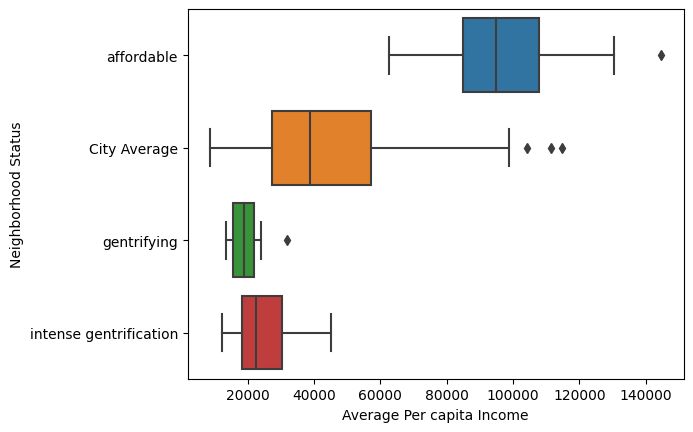

In [13]:
g = sns.boxplot(data=rf_2012, x="pcap_inc_overall", y="label")
g.set_ylabel("Neighborhood Status")
g.set_xlabel("Average Per capita Income")
g.set_facecolor(color = 'white')

In [14]:
rf_2012.label.value_counts() #seeing class imbalance originally with multi class 
rf_2012_bin = rf_2012.copy()
rf_2012_bin['label'] = np.where((rf_2012_bin['label'] == 'City Average')|(rf_2012_bin['label'] == 'affordable'),0,1) #binary encoding multi class
                                                                                             #0 not gentrifying, 1 gentrifying
rf_2012_bin.label.value_counts() #class imbalance in our dataset    

City Average              102
intense gentrification     21
affordable                 20
gentrifying                 8
Name: label, dtype: int64

0    122
1     29
Name: label, dtype: int64

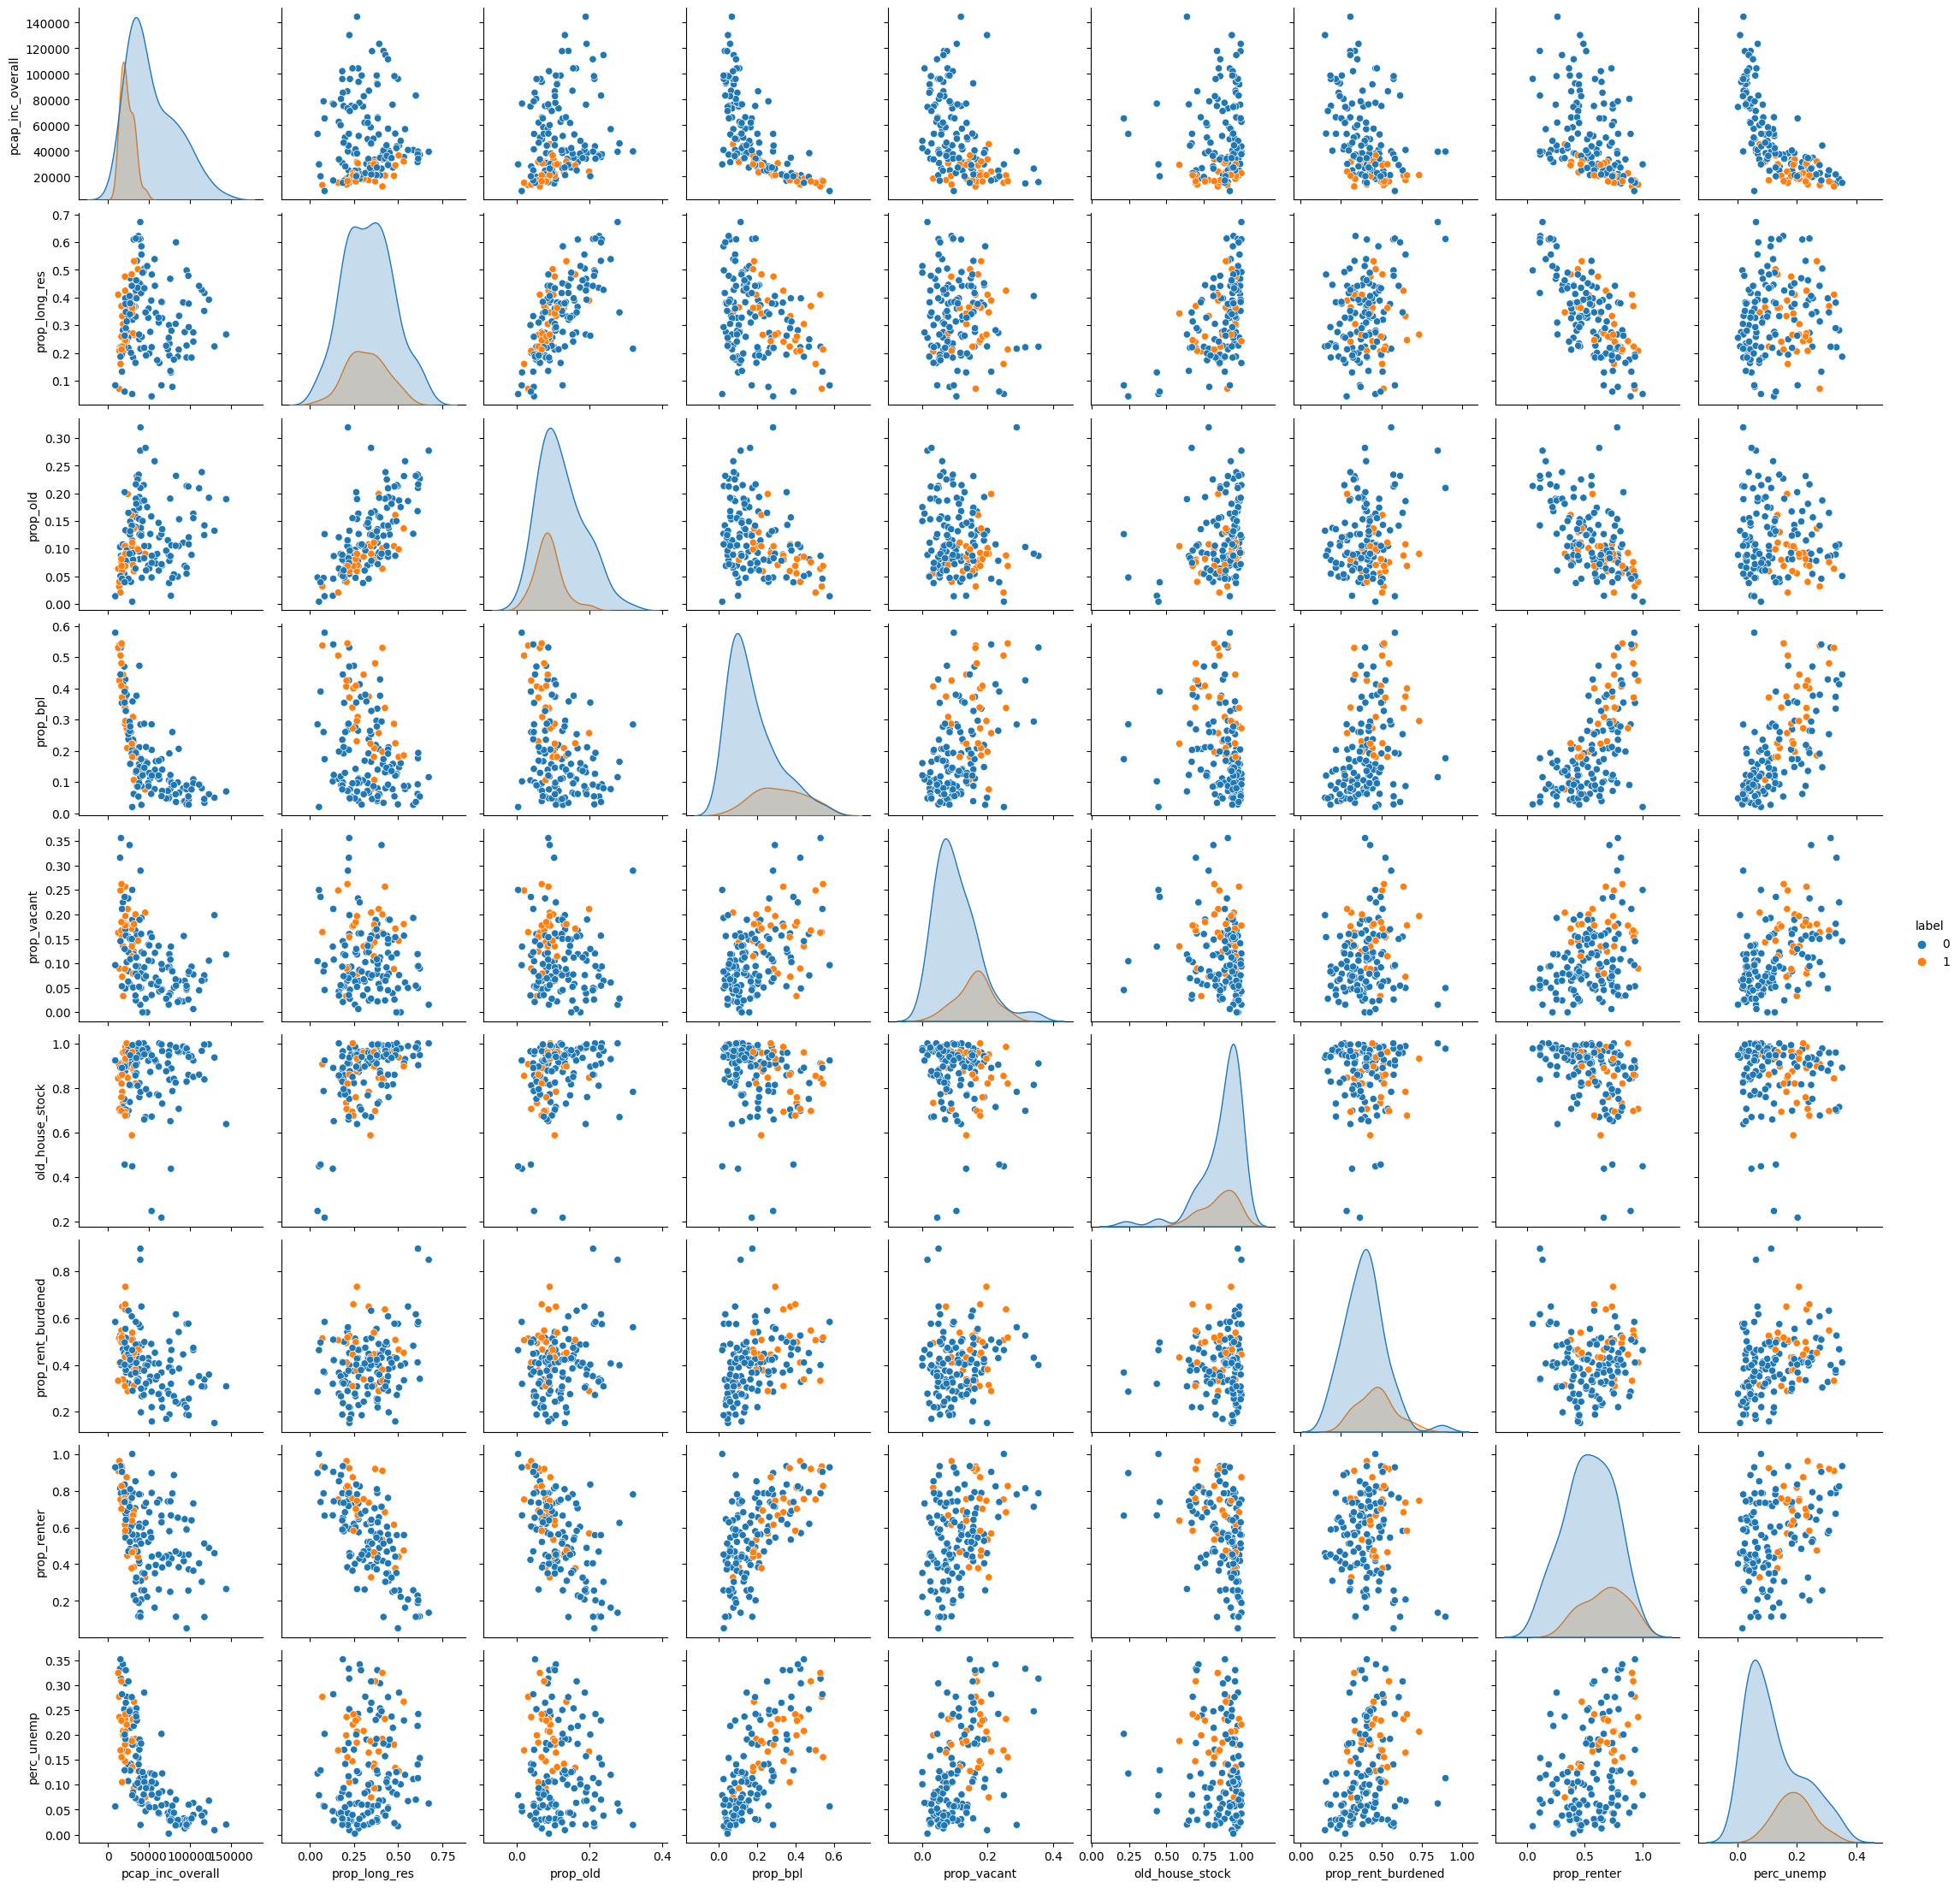

In [15]:
# sns.set(rc={'figure.figsize':(15,15)})
df = rf_2012_bin.iloc[:,2:13]
sns.pairplot(df, diag_kind='kde', hue = 'label')  

### Random Forest

In [16]:
y = np.array(rf_2012_bin['label'])
features = rf_2012_bin.drop(['label','Year','tract'], axis = 1)
feature_list = list(features.columns)
X = np.array(features)

In [17]:
#preparing scaled data for logistic regression
features_norm = MinMaxScaler().fit_transform(np.array(rf_2012_bin.drop(['label','Year','tract'], axis = 1)))
X_norm = np.array(features)

In [18]:
np.random.seed(29) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state = 42)
#SMOTE data 
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X_train, y_train)
# over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.2, stratify=over_y)

#separately for logistic
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_norm, y, test_size=0.3, stratify=y)
over_Xl, over_yl = oversample.fit_resample(Xl_train, yl_train)
# over_Xl_train, over_Xl_test, over_yl_train, over_yl_test = train_test_split(over_Xl, over_yl, test_size=0.2, stratify=over_y)

In [19]:
#Models to check with 

BRFC = BalancedRandomForestClassifier(n_estimators=150, random_state=2)
SMOTE_SRF = RandomForestClassifier(n_estimators=200, random_state=0, oob_score=True)
logistic = LogisticRegression()
gradient_booster = GradientBoostingClassifier()

#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
scoring = ('f1', 'recall', 'precision')

#Evaluate models
scores_BRFC = cross_validate(BRFC, over_X, over_y, scoring=scoring, cv=cv)
scores_SMOTE = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
score_logistic = cross_validate(logistic, over_Xl, over_yl, scoring=scoring, cv=cv)
scores_gb = cross_validate(gradient_booster, over_X, over_y, scoring=scoring, cv=cv)


#Get average evaluation metrics
print('Mean BRFC f1: %.3f' % mean(scores_BRFC['test_f1']) + ' Mean SMOTE f1: %.3f' % mean(scores_SMOTE['test_f1'])+
      ' Mean logistic f1: %.3f' % mean(score_logistic['test_f1'])+ ' Mean GB f1: %.3f' % mean(scores_gb['test_f1']))

print('Mean BRFC recall: %.3f' % mean(scores_BRFC['test_recall']) + ' Mean SMOTE recall: %.3f' % mean(scores_SMOTE['test_recall'])+
       ' Mean logitsic recall: %.3f' % mean(score_logistic['test_recall']) + ' Mean GB recall: %.3f' % mean(scores_gb['test_recall']))

print('Mean BRFC precision: %.3f' % mean(scores_BRFC['test_precision']) + ' Mean SMOTE precision: %.3f' % mean(scores_SMOTE['test_precision'])+
      ' Mean logitsic precision: %.3f' % mean(score_logistic['test_precision'])+' Mean GB precision: %.3f' % mean(scores_gb['test_precision']))


Mean BRFC f1: 0.917 Mean SMOTE f1: 0.911 Mean logistic f1: 0.086 Mean GB f1: 0.905
Mean BRFC recall: 0.958 Mean SMOTE recall: 0.951 Mean logitsic recall: 0.089 Mean GB recall: 0.946
Mean BRFC precision: 0.883 Mean SMOTE precision: 0.877 Mean logitsic precision: 0.084 Mean GB precision: 0.872


In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(5, 100, num = 11)]
# max_depth.append(None)
# min_samples_split = [1,2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': [True]}
# SMOTE_SRF = RandomForestClassifier(n_estimators=200, random_state=42, oob_score=True)
# rf_random = GridSearchCV(
#                         estimator = SMOTE_SRF, 
#                         param_grid = random_grid, 
#                         cv = 5, 
#                         n_jobs = -1, 
#                         verbose = 2)
# rf_random.fit(over_X, over_y)
# rf_random.best_params_
# rf_random.best_estimator_

In [21]:
from sklearn.metrics import balanced_accuracy_score
SMOTE_RF = RandomForestClassifier(n_estimators=2000, random_state=42,min_samples_leaf = 6,max_features= 4,oob_score=True)
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
SMOTE_RF.fit(over_X, over_y)
y_pred = SMOTE_RF.predict(X_test)


RandomForestClassifier(max_features=4, min_samples_leaf=6, n_estimators=2000,
                       oob_score=True, random_state=42)

### Performance Metrics 

In [22]:
print('MSE: %.3f' % mean_squared_error(y_test,y_pred))
print('Out of the bag score: %.3f' % SMOTE_RF.oob_score_)
print('Training accuracy: %.3f' % SMOTE_RF.score(over_X,over_y))
print('Testing accuracy: %.3f' % SMOTE_RF.score(X_test, y_test))
print('Balanced Testing accuracy: %.3f' % balanced_accuracy_score(y_test, y_pred))
print('Mean RF f1: %.3f' % mean(scores['test_f1']))
print('Mean RF recall: %.3f' % mean(scores['test_recall']))
print('Mean RF precision: %.3f' % mean(scores['test_precision']))

MSE: 0.130
Out of the bag score: 0.876
Training accuracy: 0.959
Testing accuracy: 0.870
Balanced Testing accuracy: 0.919
Mean RF f1: 0.911
Mean RF recall: 0.951
Mean RF precision: 0.877


Text(0.5, 1.0, 'Confusion Matrix')

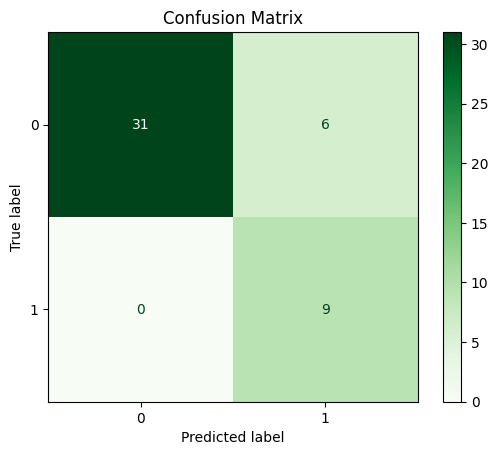

In [23]:
fig = plot_confusion_matrix(SMOTE_RF, X_test, y_test, cmap='Greens')
plt.title('Confusion Matrix')
plt.show()

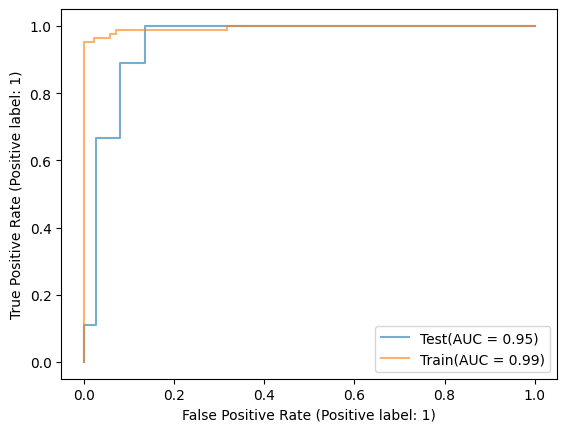

In [24]:
smote_disp = RocCurveDisplay.from_estimator(SMOTE_RF, X_test, y_test,alpha=0.6)
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(SMOTE_RF, over_X, over_y, ax=ax, alpha=0.6)
ax.set_facecolor("white")
ax.legend(('Test(AUC = 0.95)','Train(AUC = 0.99)'))
plt.show()

<AxesSubplot: >

Text(0.5, 1.0, 'Feature importances')

Text(0, 0.5, 'Mean decrease in impurity')

[Text(0, 0, 'Per capita Income'),
 Text(1, 0, 'Percentage of long term residents'),
 Text(2, 0, 'Percentage of 65+ population'),
 Text(3, 0, 'Percentage of population below poverty line'),
 Text(4, 0, 'Percentage of vacant house'),
 Text(5, 0, 'Percentage housing stocker older than 1980'),
 Text(6, 0, 'Percentage of rent burdened population'),
 Text(7, 0, 'Proportion of renters'),
 Text(8, 0, 'Percentage of unemployed population')]

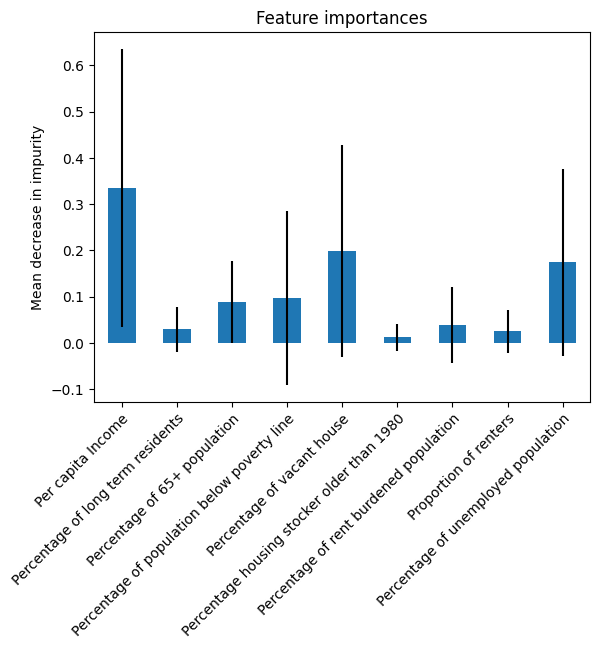

In [26]:
labels = ['Per capita Income','Percentage of long term residents', 'Percentage of 65+ population','Percentage of population below poverty line',
 'Percentage of vacant house','Percentage housing stocker older than 1980','Percentage of rent burdened population',
 'Proportion of renters','Percentage of unemployed population']
importances = SMOTE_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in SMOTE_RF.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_facecolor("white")
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
# ax.set_xticks(range(0,len(forest_importances.index)+1),labels)
ax.set_xticklabels(labels,rotation =45, ha='right' ,rotation_mode='anchor')

plt.show()

## How does supervised learning predict gentrification b/w 2012 and 2021, given labels

In [27]:
#appending second column in array, which is probability of getting 1, i.e. gentrifying 
predictions = SMOTE_RF.predict_proba(X)
gentrifying = [predictions[i][1] for i in range(len(predictions))]
rf_2012['Prob'] = gentrifying 

#creating range based labels on probability 
rf_2012['Prob_cat'] = np.where(rf_2012['Prob'] <= 0.30, '0%-30%', 0)
rf_2012['Prob_cat'] = np.where((rf_2012['Prob'] > 0.30) & (rf_2012['Prob'] < 0.5), '30%-50%', rf_2012['Prob_cat'])
rf_2012['Prob_cat'] = np.where((rf_2012['Prob'] >= 0.5) & (rf_2012['Prob'] < 0.8), '50%-80%', rf_2012['Prob_cat'])
rf_2012['Prob_cat'] = np.where(rf_2012['Prob'] >= 0.80, '>80%', rf_2012['Prob_cat'])

<AxesSubplot: >

(-8586103.193779986, -8560343.574179746, 4690409.992130087, 4722536.728137838)

Text(0.5, 1.0, 'Probability of Census Tracts in DC facing gentrification 2021(predicted on 2000 data)')

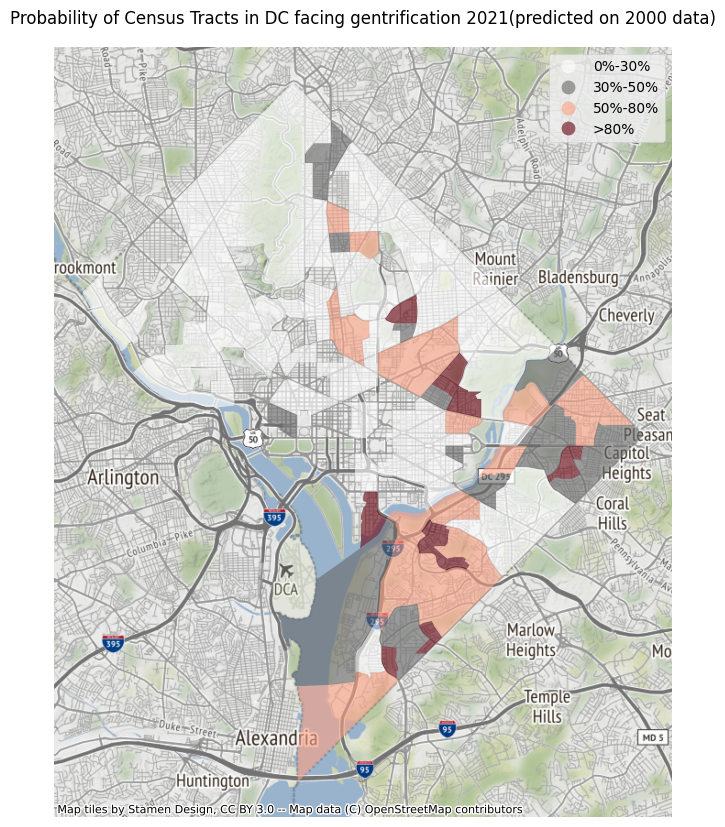

In [38]:
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

top = cm.get_cmap('Greys', 128) # r means reversed version
bottom = cm.get_cmap('Reds', 128)
# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
# create a new colormaps with a name of OrangeBlue
grey_red = ListedColormap(newcolors, name='OrangeBlue')

dc_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_11_tract.zip")
rf_merge = dc_tract.merge(rf_2012, left_on = "TRACTCE", right_on = 'tract', how = 'right')
rf_merge_base = rf_merge.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))

# add the layer with ax=ax in the argument 
rf_merge_base.plot(column = "Prob_cat",
                       ax = ax,
                       cmap = grey_red,
                    alpha=0.6,
                       legend = True)
plt.style.use('bmh')
ax.axis('off')

ax.set_title('Probability of Census Tracts in DC facing gentrification 2021(predicted on 2000 data)',fontsize=12)

ctx.add_basemap(ax)

<AxesSubplot: >

(-8575385.904237892, -8561322.968625722, 4695207.220166801, 4717083.056304108)

Text(0.5, 1.0, 'Probability of Census Tracts in DC facing gentrification 2021(predicted on 2000 data)')

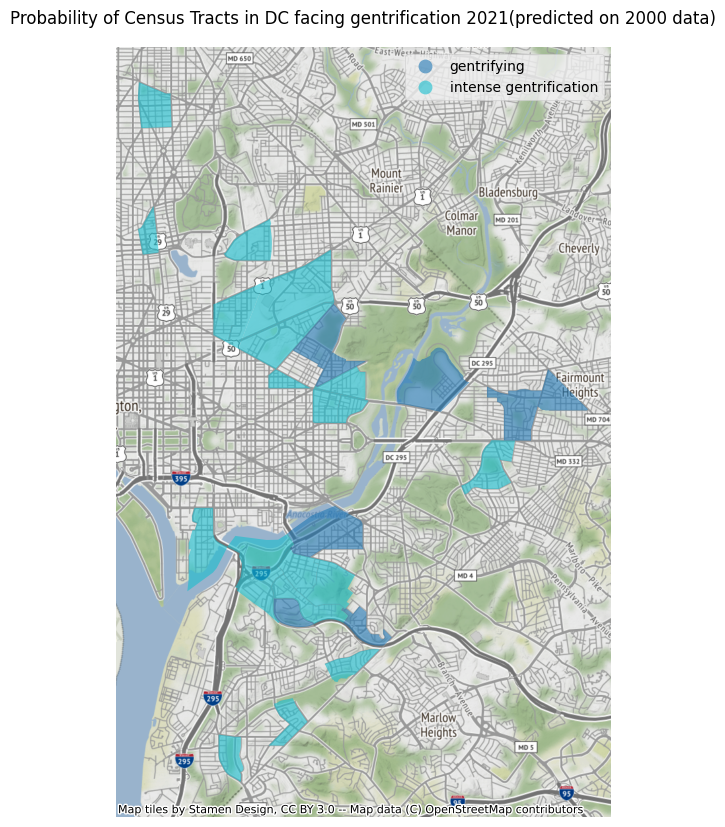

In [29]:
dc_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_11_tract.zip")
rf_merge = dc_tract.merge(rf_2012, left_on = "TRACTCE", right_on = 'tract', how = 'right')
rf_merge_base = rf_merge.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))

# add the layer with ax=ax in the argument 
rf_merge_base[(rf_merge_base.label == 'gentrifying')|(rf_merge_base.label == 'intense gentrification')].plot(column = "label",
                       ax = ax,

                    alpha=0.6,
                       legend = True)
plt.style.use('bmh')
ax.axis('off')

ax.set_title('Probability of Census Tracts in DC facing gentrification 2021(predicted on 2000 data)',fontsize=12)

ctx.add_basemap(ax)

### Final use case: Predicting gentrification b/w 2021 and 2030

<AxesSubplot: >

(-8586103.193779986, -8560343.574179746, 4690409.992130087, 4722536.728137838)

Text(0.5, 1.0, 'Probability of Census Tracts in DC facing gentrification 2030(predicted on 2021 data)')

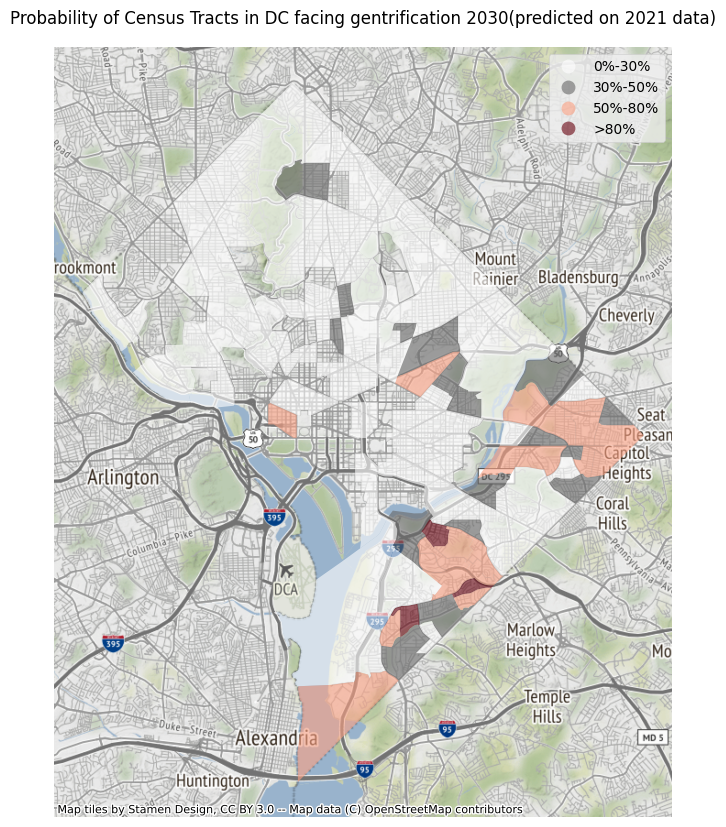

In [40]:
rf_2021 = rf_df[rf_df.Year == 2021].dropna()
features_2021 = rf_2021.drop(['Year','tract'], axis = 1)
X_prediction = np.array(features_2021)

predictions = SMOTE_RF.predict_proba(X_prediction)
gentrifying = [predictions[i][1] for i in range(len(predictions))]

rf_2021['Prob'] = gentrifying 
rf_2021['Prob_cat'] = np.where(rf_2021['Prob'] <= 0.30, '0%-30%', 0)
rf_2021['Prob_cat'] = np.where((rf_2021['Prob'] > 0.30) & (rf_2021['Prob'] < 0.5), '30%-50%', rf_2021['Prob_cat'])
rf_2021['Prob_cat'] = np.where((rf_2021['Prob'] >= 0.5) & (rf_2021['Prob'] < 0.8), '50%-80%', rf_2021['Prob_cat'])
rf_2021['Prob_cat'] = np.where(rf_2021['Prob'] >= 0.80, '>80%', rf_2021['Prob_cat'])

rf_2021_merge = dc_tract.merge(rf_2021, left_on = "TRACTCE", right_on = 'tract', how = 'right')
rf_merge_base_2021 = rf_2021_merge.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))

rf_merge_base_2021.plot(column = "Prob_cat",
                       ax = ax,
                       cmap = grey_red,
                    alpha=0.6,
                       legend = True)
plt.style.use('bmh')
ax.axis('off')

ax.set_title('Probability of Census Tracts in DC facing gentrification 2030(predicted on 2021 data)',fontsize=12)
ctx.add_basemap(ax)

In [31]:
filename = '../gentrification_rf_model.sav'
pickle.dump(SMOTE_RF, open(filename, 'wb'))